In [1]:
import pandas as pd
unkai_df = pd.read_csv("./雲海2007.csv", header=1)
unkai_df.head()

,日付,出現,確率,閾値40,閾値50,閾値60,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,2007/6/19,無,60%,空振り,空振り,空振り,テラスは雲中、トマム山山頂で雲海見えた（客談）,NaN,NaN,NaN,NaN,NaN
1,2007/6/20,無,50%,空振り,空振り,適中なし,とても寒く雲海無し,NaN,NaN,NaN,NaN,NaN
2,2007/6/21,無,50%,空振り,空振り,適中なし,雨で営業中止,NaN,NaN,NaN,NaN,NaN
3,2007/6/22,無,60%,空振り,空振り,空振り,曇り時々霧、６時過ぎに多少発生,NaN,NaN,NaN,NaN,NaN
4,2007/6/23,有,70%,適中,適中,適中,５時前後に雲海発生、5:30頃から雷雨で営業中止,NaN,NaN,NaN,NaN,NaN


In [2]:
target_df = unkai_df.loc[unkai_df["閾値40"] == "空振り"]
target_df.head()

,日付,出現,確率,閾値40,閾値50,閾値60,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,2007/6/19,無,60%,空振り,空振り,空振り,テラスは雲中、トマム山山頂で雲海見えた（客談）,NaN,NaN,NaN,NaN,NaN
1,2007/6/20,無,50%,空振り,空振り,適中なし,とても寒く雲海無し,NaN,NaN,NaN,NaN,NaN
2,2007/6/21,無,50%,空振り,空振り,適中なし,雨で営業中止,NaN,NaN,NaN,NaN,NaN
3,2007/6/22,無,60%,空振り,空振り,空振り,曇り時々霧、６時過ぎに多少発生,NaN,NaN,NaN,NaN,NaN
7,2007/6/26,無,50%,空振り,空振り,適中なし,朝一雲海発生していたが、営業中は雲中,NaN,NaN,NaN,NaN,NaN


In [3]:
target_dates = target_df["日付"].to_numpy()
target_dates

array(['2007/6/19', '2007/6/20', '2007/6/21', '2007/6/22', '2007/6/26',
       '2007/6/27', '2007/6/28', '2007/7/2', '2007/7/3', '2007/7/5',
       '2007/7/6', '2007/7/7', '2007/7/12', '2007/7/13', '2007/7/24',
       '2007/7/25', '2007/7/26', '2007/7/28', '2007/7/29', '2007/8/1',
       '2007/8/2', '2007/8/5', '2007/8/6', '2007/8/7', '2007/8/8',
       '2007/8/9', '2007/8/10', '2007/8/11', '2007/8/12', '2007/8/14',
       '2007/8/15', '2007/8/16', '2007/8/17', '2007/8/18', '2007/8/21',
       '2007/8/23', '2007/8/24', '2007/8/26', '2007/8/27', '2007/8/28',
       '2007/8/29', '2007/8/30', '2007/9/2', '2007/9/3', '2007/9/9',
       '2007/9/10', '2007/9/11', '2007/9/12', '2007/9/13', '2007/9/14',
       '2007/9/15', '2007/9/19', '2007/9/20', '2007/9/21', '2007/9/22',
       '2007/9/23', '2007/9/24', '2007/9/25', '2007/9/26', '2007/9/27',
       '2007/9/29', '2007/9/30', '2007/10/7', '2007/10/10', '2007/10/11',
       '2007/10/12', '2007/10/13', '2007/10/14', '2007/10/20',
       '2007/1

In [4]:
def inquire_grib_data(path):
    import pygrib                  # gribファイルの中身を見たい場合はinquire_grib_data(path)を実行                
    grbs = pygrib.open(path)
    for grb in grbs:
        print(grb)
    return
def read_grib_data(path,name=None,level=None):
    import numpy as np
    import pygrib                   # pygribは!pip3 install pygrib --userでインストール
    grbs = pygrib.open(path)

    if name != None:                # anl_surf125に対しては変数名を与える
        alines = grbs.select(name=name)
    elif level != None:             # anl_p125に対しては気圧面を与えるとその水平面データ
        alines = grbs.select(level=level)
    else:                           #                  気圧面を与えないと全３次元データ
        alines = grbs.select()

    lat, lon = alines[0].latlons()  # lonは経度、latは緯度データ: (ny,nx)の２次元格子です
    ny, nx = lat.shape
    nline = len(alines)
    gdata = np.empty( (nline,ny,nx), dtype = "f4" )
    levels = np.empty( (nline), dtype = "f4" )
    for iline, aline in enumerate(alines):
        gdata[iline,:,:] = aline.values[::-1,:]
        levels[iline] = aline["level"]

    return lon, lat[::-1], level, gdata

In [5]:
import datetime as dt
import calendar as cal
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

dts=[]
for m in range(12):
    month=m+1
    nmonth=cal.monthrange(2007,month)[1]
    dts.extend([dt.datetime(2007,month,1,0)+dt.timedelta(hours=6*i) for i in range(nmonth*4)])  #一年分の平均

parameter_counts = 4
slpm=np.zeros((len(dts),145,288, parameter_counts)) #データの置き場所をつくる
#slpm[target_idxes, :, :] /= 100

for i,dt in enumerate(dts):
    fdir = "/mnt/hwmet-hdd01/Database/JRA55/anl_p125/"
    fname = "/anl_surf125."
    path=dt.strftime(fdir+"%Y%m"+fname+"%Y%m%d%H")
    lon,lat,_,SLP0=read_grib_data(path,name="Mean sea level pressure")
    lon,lat,_, u_wind = read_grib_data(path, name="10 metre U wind component")
    lon,lat,_, v_wind = read_grib_data(path,name="10 metre V wind component")
    slpm[i, :, :, 1] = SLP0
    slpm[i, :, :, 2] = u_wind
    slpm[i, :, :, 3] = v_wind

target_idxes = []
for idx, d in enumerate(dts):
    string_dt = f"{d.year}/{d.month}/{d.day}"
    if string_dt in target_dates:
#         print(idx, string_dt)
        target_idxes.append(idx)

slpm[target_idxes, :, :, 1] /= 100
print(target_idxes)

/home/konagai/.local/lib/python3.6/site-packages/pyproj/__init__.py:76: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


[676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 728, 729, 730, 731, 732, 733, 734, 735, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 768, 769, 770, 771, 772, 773, 774, 775, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 832, 833, 834, 835, 836, 837, 838, 839, 848, 849, 850, 851, 852, 853, 854, 855, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 928, 929, 930, 931, 936, 937, 938, 939, 940, 941, 942, 943, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 976, 977, 978, 979, 980, 981, 982, 983, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023,

In [6]:
mean = np.mean(slpm[target_idxes, :, :, 1], axis=0)
mean

array([[1034.11109982, 1034.11109982, 1034.11109982, ..., 1034.11109982,
        1034.11109982, 1034.11109982],
       [1033.01925016, 1033.01925016, 1033.21224002, ..., 1032.68774678,
        1032.8180255 , 1033.01925016],
       [1031.09009053, 1031.12704154, 1031.83301705, ..., 1030.24475692,
        1030.3180255 , 1031.05166148],
       ...,
       [1011.01639965, 1011.01397144, 1010.9261336 , ..., 1011.11658969,
        1011.10603225, 1011.02051705],
       [1011.03624762, 1011.03624762, 1011.00035235, ..., 1011.10962178,
        1011.07805506, 1011.03624762],
       [1011.15903056, 1011.15903056, 1011.15903056, ..., 1011.15903056,
        1011.15903056, 1011.15903056]])

In [7]:
mean2 = np.mean(slpm[target_idxes, :, :, 2], axis=0)
mean2

array([[-3.45431972, -3.38052326, -3.30371794, ..., -3.66747428,
        -3.59821752, -3.52706042],
       [-5.56691473, -5.56691473, -5.39345612, ..., -5.84848146,
        -5.72078931, -5.56691473],
       [-6.06775933, -6.05450975, -5.66684083, ..., -6.47870738,
        -6.43283534, -6.08085054],
       ...,
       [ 0.6969155 ,  0.69343155,  0.60348223, ...,  0.78649532,
         0.77482936,  0.69929093],
       [ 0.5628889 ,  0.5628889 ,  0.49273476, ...,  0.69575419,
         0.62871449,  0.5628889 ],
       [ 0.33226179,  0.28850123,  0.24394887, ...,  0.46317395,
         0.41920224,  0.37560005]])

In [8]:
mean3 = np.mean(slpm[target_idxes, :, :, 3], axis=0)
mean3

array([[-3.37204737, -3.44616055, -3.51979864, ..., -3.13872812,
        -3.21780328, -3.29550599],
       [-3.59016393, -3.59016393, -3.83631046, ..., -3.05405751,
        -3.31662085, -3.59016393],
       [-4.27697769, -4.2843679 , -4.61613521, ..., -3.83071502,
        -3.8867222 , -4.26858453],
       ...,
       [-1.58013437, -1.58182356, -1.62806511, ..., -1.50987465,
        -1.51684256, -1.57707271],
       [-1.6959494 , -1.6959494 , -1.71695869, ..., -1.64337339,
        -1.66744433, -1.6959494 ],
       [-2.00686578, -2.0142032 , -2.01974585, ..., -1.98136959,
        -1.99097685, -1.99989788]])

980.2010491448478 1043.6794064083615


/home/konagai/.local/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/konagai/.local/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/konagai/.local/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/konagai/.local/lib/python3.6/site-packages/cartopy/crs.py:385: ShapelyDep

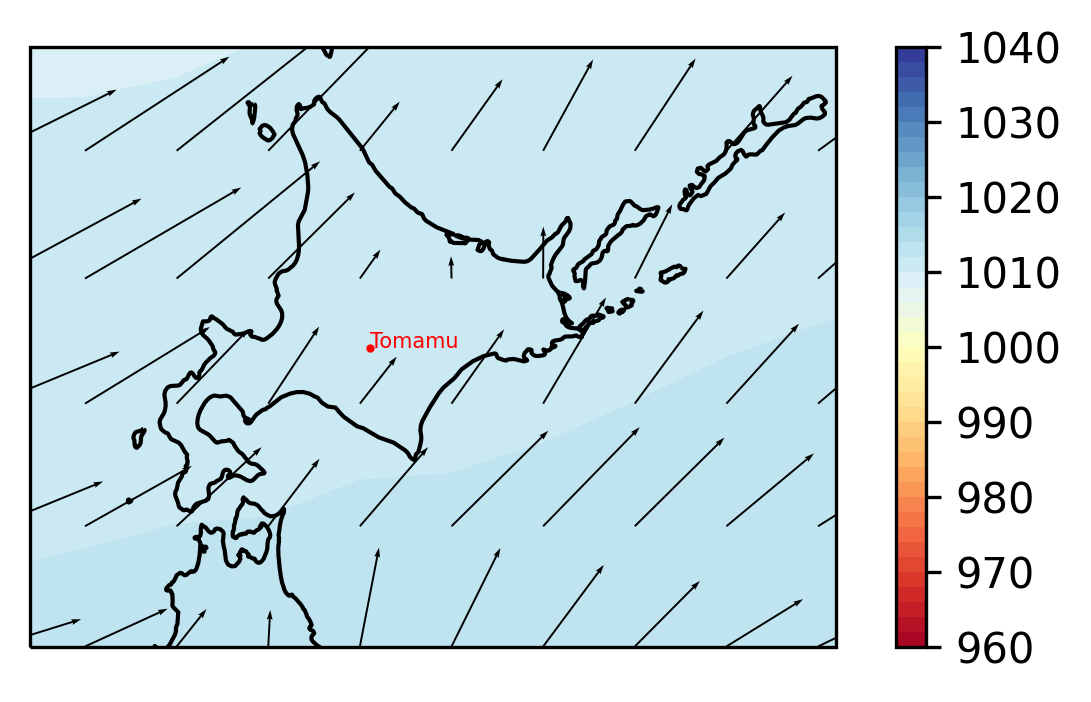

In [9]:
def draw_graph(xmesh,ymesh,topo_data):
    import numpy as np
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    fig = plt.figure( figsize = (5,2.5), dpi = 300 )
    proj = ccrs.Mercator(central_longitude=140)
    proj_cart = ccrs.PlateCarree()
    ax = plt.axes((0.1,0.1,0.8,0.8), projection=proj)
    ax.set_extent([120,160,25,50],crs=proj_cart)
#   ax.set_extent([-179.99,180,-80,80],crs=proj_cart)
    ax.coastlines()
    
    C = ax.contourf(xmesh,ymesh,topo_data,cmap="RdYlBu",transform=proj_cart)
    fig.colorbar(C)
    return ax

# ax = draw_graph(lon,lat,mean)

xmesh, ymesh, topo_data = lon, lat, mean 

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure( figsize = (5,2.5), dpi = 300 )
proj = ccrs.Mercator(central_longitude=140)
proj_cart = ccrs.PlateCarree()
ax = plt.axes((0.1,0.1,0.8,0.8), projection=proj)
ax.set_extent([138,149,40,46],crs=proj_cart)
ax.coastlines()

lat_tomamu = 43.0631836
lon_tomamu = 142.6316828
ax.plot(lon_tomamu, lat_tomamu, 'o', transform=ccrs.PlateCarree(),markersize=1, color='r')
plt.text(lon_tomamu, lat_tomamu, 'Tomamu', size=5, color='red',horizontalalignment='left', transform=ccrs.PlateCarree())

# fig.savefig("適中の日の平均風向")

###等高線と色付け
# Cmap: RdYlBu
min_press, max_press = topo_data.min(), topo_data.max()
print(min_press, max_press)
levels = np.arange(960.0, 1040.1, 2.0)
C = ax.contourf(xmesh,ymesh,topo_data, levels=levels, cmap="RdYlBu",transform=proj_cart)
fig.colorbar(C)
colors = ['black']
# mappable = ax.contour(lon,lat,mean,levels=levels, colors=["black"], extend='both', transform=ccrs.PlateCarree())
# 等圧線の数値表示
# ax.clabel(mappable, fontsize=2, fmt="%4.0f", inline=False)

###風
ax.quiver(lon, lat, mean2, mean3, scale=5, scale_units="inches", transform=ccrs.PlateCarree())


ax.set_extent([138,149,40,46],crs=proj_cart)
# ax.gridlines(draw_labels=True)
plt.savefig("空振り天気図.png")
plt.show()
plt.close()
#draw_graph(lon,lat,mean)